In [1]:
import os
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
from utils.exp_utils import list_concept_names, list_exp_names

In [ ]:
class ExpScoreKeeper:
    def __init__(self, base_path, dataset_name, exp_name, model_name, step=None):
        self.base_path = base_path
        self.dataset_name = dataset_name
        self.exp_name = exp_name
        self.model_name = model_name
        self.score_path = f"{base_path}/{dataset_name}/{exp_name}_{model_name}.pkl"
        if step is not None:
            self.score_path = f"{base_path}/{dataset_name}/stepwise/{exp_name}/{exp_name}_{model_name}{step}.pkl"
            self.exp_name = f"{step}_{exp_name}"
        
        if not os.path.exists(self.score_path):
            raise FileNotFoundError(f"Score file {self.score_path} does not exist.")
        with open(self.score_path, "rb") as f:
            self.data = pk.load(f)

        self.concept = sorted(list(self.data.keys()))
        for concept in self.concept:
            self.data[concept]['final_score'] = (
                self.data[concept]['consistency_score'] 
                - self.data[concept]['distinction_score']
                + self.data[concept]['relevance_score']
            )

        self.metric = {
            "consistency_score": [],
            "distinction_score": [],
            "relevance_score": [],
            "final_score": [],
            "v0v0_score": [],
            "v1v1_score": [],
            "v2v2_score": [],
            "v0v1_score": [],
            "v0v2_score": [],
            "v1v2_score": []
        }

        for metric in self.metric.keys():
            self.metric[metric] = [
                np.mean([self.data[concept][metric] for concept in self.concept]),
                np.std([self.data[concept][metric] for concept in self.concept])
            ]

    def __str__(self):
        return f"""
Concept: {self.concept}
Concept Length: {len(self.concept)}
Base Path: {self.base_path}
Dataset Name: {self.dataset_name}
Experiment Name: {self.exp_name}
Model Name: {self.model_name}
Final Score: {self.metric['final_score'][0]}
Final Score Std: {self.metric['final_score'][1]}
"""
    
    def show_aspect_score(self):
        print(
f"""
Aspect Scores:
Consistency: {self.metric['consistency_score'][0]}
Distinction: {self.metric['distinction_score'][0]}
relevance: {self.metric['relevance_score'][0]}

Consistency Std: {self.metric['consistency_score'][1]}
Distinction Std: {self.metric['distinction_score'][1]}
relevance Std: {self.metric['relevance_score'][1]}
"""
        )
    
    def show_node_score(self):
        print(
f"""
Node Scores:
V0V0: {self.metric['v0v0_score'][0]}
V1V1: {self.metric['v1v1_score'][0]}
V2V2: {self.metric['v2v2_score'][0]}
V0V1: {self.metric['v0v1_score'][0]}
V0V2: {self.metric['v0v2_score'][0]}
V1V2: {self.metric['v1v2_score'][0]}
V0V0 Std: {self.metric['v0v0_score'][1]}
V1V1 Std: {self.metric['v1v1_score'][1]}
V2V2 Std: {self.metric['v2v2_score'][1]}
V0V1 Std: {self.metric['v0v1_score'][1]}
V0V2 Std: {self.metric['v0v2_score'][1]}
V1V2 Std: {self.metric['v1v2_score'][1]}
"""
        )
        
    def show_concept_score(self, concept):
        if concept not in self.concept:
            raise ValueError(f"Concept {concept} not found in the experiment data.")
        print(
f"""
Scores for concept {concept} in experiment {self.exp_name}:
Consistency: {self.data[concept]['consistency_score']}
Distinction: {self.data[concept]['distinction_score']}
Relevance: {self.data[concept]['relevance_score']}
Final: {self.data[concept]['final_score']}
V0V0: {self.data[concept]['v0v0_score']}
V1V1: {self.data[concept]['v1v1_score']}
V2V2: {self.data[concept]['v2v2_score']}
V0V1: {self.data[concept]['v0v1_score']}
V0V2: {self.data[concept]['v0v2_score']}
V1V2: {self.data[concept]['v1v2_score']}
"""
        )



In [5]:
base_path = "/home/jack/Code/Research/instree_analysis/experiment_image/scores"
exp_path = "/home/jack/Code/Research/instree_analysis/experiments"
dataset_name = "v2_sub_clip"

exp_names = list_exp_names(dataset_name, exp_path)
cpt_names = list_concept_names(dataset_name)

===== Experiment names for v2_sub_clip: =====
0 20250425_instree_fixed
1 20250511_my_method
2 20250512_abla_no_attn
3 20250512_abla_no_us
4 20250514_my_method_pred_mask
5 20250516_ema
6 20250517_ema_original
7 20250518_ema_batch_mean
8 20250519_0517_otsu
9 20250520_high_ema_low_rand
10 20250521_0520_res_16
11 20250522_0521_rand_300
12 20250522_0521_rand_later
===== Total experiments: 13 =====
===== Concept names for v2_sub_clip: =====
buddha
canada_bear
cat_statue
colorful_teapot
decoritems_woodenpot
elephant
green_dall
mug_buildings
mug_skulls
physics_mug
plushie_tortoise
red_teapot
round_bird
===== Total concepts: 13 =====


In [31]:
exp_idx = list(range(len(exp_names)))
analysis_name = [exp_names[i] for i in exp_idx]
sk_list = []

for exp_name in analysis_name:
    print(f"Loading {dataset_name} {exp_name}")
    sk_list.append(ExpScoreKeeper(base_path, dataset_name, exp_name, "clip"))

Loading v2_sub_clip 20250425_instree_fixed
Loading v2_sub_clip 20250511_my_method
Loading v2_sub_clip 20250512_abla_no_attn
Loading v2_sub_clip 20250512_abla_no_us
Loading v2_sub_clip 20250514_my_method_pred_mask
Loading v2_sub_clip 20250516_ema
Loading v2_sub_clip 20250517_ema_original
Loading v2_sub_clip 20250518_ema_batch_mean
Loading v2_sub_clip 20250519_0517_otsu
Loading v2_sub_clip 20250520_high_ema_low_rand
Loading v2_sub_clip 20250521_0520_res_16
Loading v2_sub_clip 20250522_0521_rand_300
Loading v2_sub_clip 20250522_0521_rand_later


In [ ]:
exp_idx = [0]
analysis_name = [exp_names[i] for i in exp_idx]
sk_dict = {}

for exp_name in analysis_name:
    print(f"Loading Stepwise {dataset_name} {exp_name}")
    sk_list = []
    for step in range(100, 1001, 100):
        sk_list.append(ExpScoreKeeper(base_path, dataset_name, exp_name, "clip", step))
    sk_dict[exp_name] = sk_list

In [ ]:
# https://docs.google.com/spreadsheets/d/1MZJcoBtVKAhKgnQlZky_cfkGL1vAevpiiODSi3rdIzs/edit?gid=0#gid=0

def tab_separated_result(sk, name):
    result = [
        sk.metric['consistency_score'][0],
        sk.metric['distinction_score'][0],
        sk.metric['relevance_score'][0],
        sk.metric['final_score'][0],
        sk.metric['v0v0_score'][0],
        sk.metric['v1v1_score'][0],
        sk.metric['v2v2_score'][0],
        sk.metric['v0v1_score'][0],
        sk.metric['v0v2_score'][0],
        sk.metric['v1v2_score'][0]
    ]
    result = [name] + [str(round(r, 4)) for r in result]
    print("\t".join([r for r in result]))


def tab_separated_result_concept(sk):
    for concept in sk.concept:
        result = [
            sk.data[concept]['consistency_score'],
            sk.data[concept]['distinction_score'],
            sk.data[concept]['relevance_score'],
            sk.data[concept]['final_score'],
            sk.data[concept]['v0v0_score'],
            sk.data[concept]['v1v1_score'],
            sk.data[concept]['v2v2_score'],
            sk.data[concept]['v0v1_score'],
            sk.data[concept]['v0v2_score'],
            sk.data[concept]['v1v2_score']
        ]
        result = [concept] + [str(round(r, 4)) for r in result]
        print("\t".join([r for r in result]))

In [58]:
print("Aspect\tConsistency\tDistinction\tRelevance\tFinal Score\tV0V0\tV1V1\tV2V2\tV0V1\tV0V2\tV1V2")

# for sk, name in zip(sk_list, analysis_name):
#     tab_separated_result(sk, name)

for sk, name in zip(sk_list, analysis_name):
    print(name)
    tab_separated_result_concept(sk)
    
# for sk, name in zip(sk_list, analysis_name):
#     print(f"===== Exp: {name} =====")
#     print(sk)
#     sk.show_aspect_score()
#     sk.show_concept_score('red_teapot')

Aspect	Consistency	Distinction	Relevance	Final Score	V0V0	V1V1	V2V2	V0V1	V0V2	V1V2
20250425_instree_fixed
buddha	1.6331	0.5699	1.4522	2.5154	0.9336	0.7606	0.8725	0.6383	0.8139	0.5699
canada_bear	1.3942	0.519	1.2984	2.1736	0.9662	0.6947	0.6995	0.6543	0.6441	0.519
cat_statue	1.5708	0.5519	1.3594	2.3783	0.9139	0.7849	0.7859	0.6819	0.6775	0.5519
colorful_teapot	1.3848	0.5632	1.3604	2.182	0.9499	0.7783	0.6066	0.7869	0.5735	0.5632
decoritems_woodenpot	1.4008	0.5343	1.1769	2.0433	0.9645	0.7671	0.6337	0.7013	0.4755	0.5343
elephant	1.4662	0.6198	1.1983	2.0447	0.9345	0.7784	0.6878	0.6176	0.5806	0.6198
green_dall	1.349	0.5084	1.1938	2.0344	0.908	0.7613	0.5877	0.5843	0.6094	0.5084
mug_buildings	1.3121	0.4713	1.1681	2.0089	0.93	0.7506	0.5616	0.6616	0.5065	0.4713
mug_skulls	1.259	0.4596	1.0861	1.8856	0.9374	0.7829	0.4761	0.6665	0.4196	0.4596
physics_mug	1.3323	0.487	1.2194	2.0647	0.8256	0.694	0.6383	0.6239	0.5954	0.487
plushie_tortoise	1.546	0.5693	1.3358	2.3126	0.9329	0.7615	0.7845	0.7214	0.6144	0.

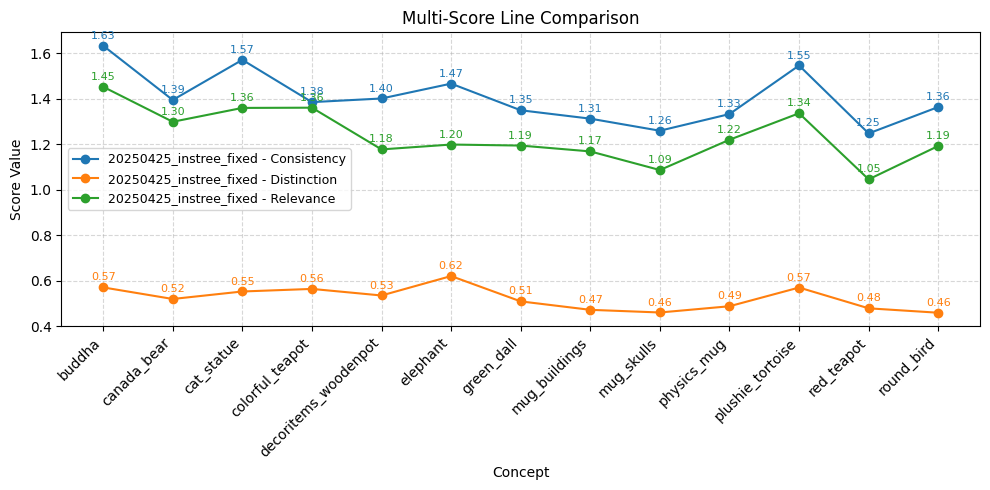

In [51]:
def plot_concept_multi_field_line_comparison_with_labels(dict_list, fields=['consistency', 'distinction', 'relevance'], title='Multi-Score Line Comparison'):
    label_list = [d.exp_name for d in dict_list]
    
    # 找出共通的 concept
    concept_sets = [set(d.concept) for d in dict_list]
    common_concepts = sorted(set.intersection(*concept_sets))
    
    if not common_concepts:
        print("No common concepts to compare.")
        return

    x = np.arange(len(common_concepts))
    fig, ax = plt.subplots(figsize=(10, 5))

    # 顏色與線型設計
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    linestyles = ['-', '--', '-.', ':']

    for i, d in enumerate(dict_list):
        for j, field in enumerate(fields):
            scores = [d.data[c][f"{field}_score"] for c in common_concepts]
            label = f"{label_list[i]} - {field.capitalize()}"
            color = colors[j % len(colors)]
            linestyle = linestyles[i % len(linestyles)]

            # 繪圖
            ax.plot(x, scores, label=label, linestyle=linestyle, marker='o', color=color)

            # 標上數值
            for xi, yi in zip(x, scores):
                ax.annotate(f'{yi:.2f}', xy=(xi, yi), xytext=(0, 5),
                            textcoords="offset points", ha='center', fontsize=8, color=color)

    ax.set_xlabel('Concept')
    ax.set_ylabel('Score Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_concepts, rotation=45, ha='right')
    ax.legend(loc='best', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_concept_multi_field_line_comparison_with_labels([sk_list[0]])

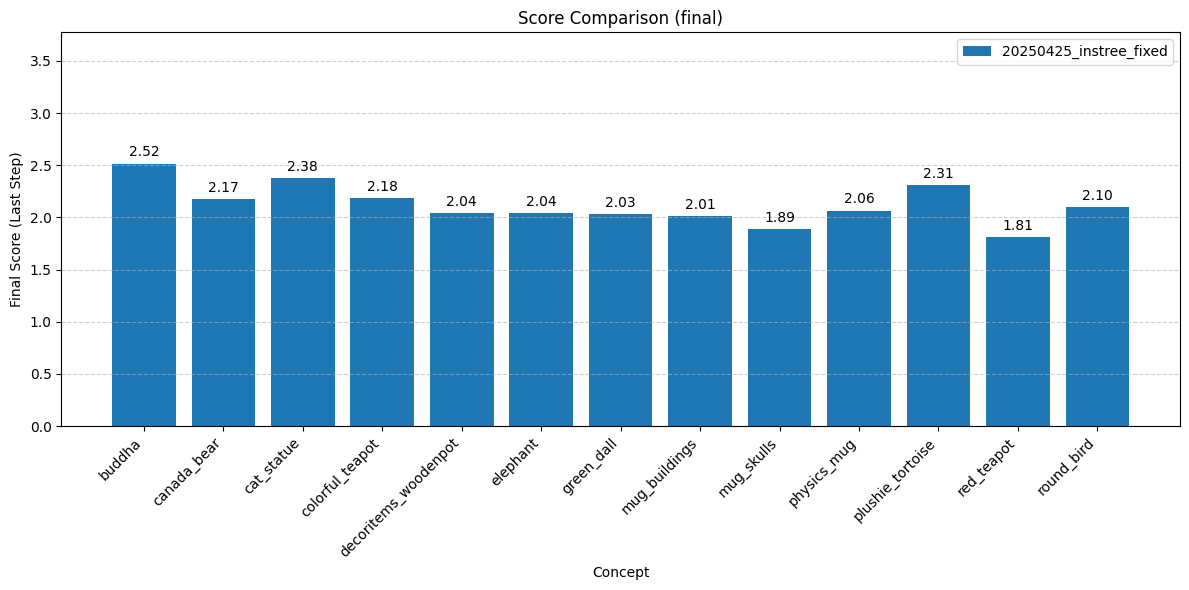

In [ ]:
def plot_concept_comparison(dict_list, field='final', title='Score Comparison'):
    title += " ({})".format(field)
    label_list = [dict.exp_name for dict in dict_list]
    
    # Get common concepts across all dictionaries
    concept_sets = [set(d.concept) for d in dict_list]
    common_concepts = sorted(set.intersection(*concept_sets))
    
    if not common_concepts:
        print("No common concepts to compare.")
        return

    n_dicts = len(dict_list)
    x = np.arange(len(common_concepts))
    width = 0.8 / n_dicts  # Adjust total bar width

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (d, label) in enumerate(zip(dict_list, label_list)):
        scores = [d.data[c][field+"_score"] for c in common_concepts]
        bars = ax.bar(x + i * width - (n_dicts - 1) * width / 2, scores, width, label=label)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xlabel('Concept')
    ax.set_ylabel('Final Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_concepts, rotation=45, ha='right')
    ylim = max(max([d.data[c][field+"_score"] for c in common_concepts]) for d in dict_list)  * 1.5
    ax.set_ylim(0, ylim)
    ax.legend(loc='best')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_concept_comparison([sk_list[0]])


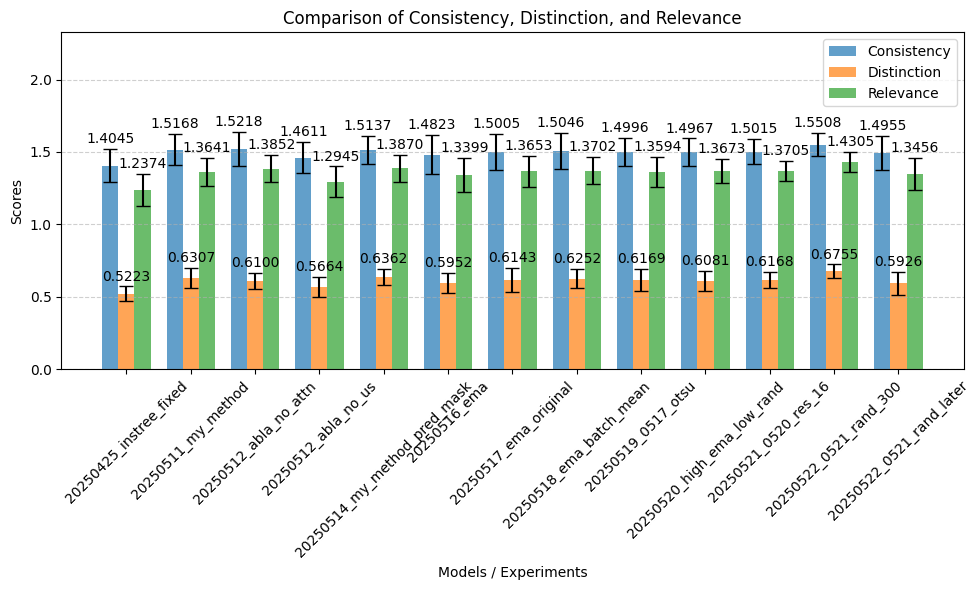

In [53]:
def plot_all_scores_one_plot(score_keepers):
    # Extracting model names and experiment names
    model_names = [sk.model_name for sk in score_keepers]
    exp_names = [sk.exp_name for sk in score_keepers]

    # Metrics data
    metrics = ["consistency", "distinction", "relevance"]
    means = {
        metric: [getattr(sk, f"metric")["{}_score".format(metric)][0] for sk in score_keepers]
        for metric in metrics
    }
    stds = {
        metric: [getattr(sk, f"metric")["{}_score".format(metric)][1] for sk in score_keepers]
        for metric in metrics
    }

    x = np.arange(len(score_keepers))  # x locations for the bars
    width = 0.25  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plots for each metric
    ax.bar(x - width, means["consistency"], width, yerr=stds["consistency"], capsize=5, label='Consistency', alpha=0.7)
    ax.bar(x, means["distinction"], width, yerr=stds["distinction"], capsize=5, label='Distinction', alpha=0.7)
    ax.bar(x + width, means["relevance"], width, yerr=stds["relevance"], capsize=5, label='Relevance', alpha=0.7)

    # Add numerical values on top of the bars
    for i in range(len(score_keepers)):
        ax.text(x[i] - width, means["consistency"][i] + stds["consistency"][i] + 0.02,  # Position above the bar
                f'{means["consistency"][i]:.4f}', ha='center', va='bottom', color='black')
        ax.text(x[i], means["distinction"][i] + stds["distinction"][i] + 0.02,  # Position above the bar
                f'{means["distinction"][i]:.4f}', ha='center', va='bottom', color='black')
        ax.text(x[i] + width, means["relevance"][i] + stds["relevance"][i] + 0.02,  # Position above the bar
                f'{means["relevance"][i]:.4f}', ha='center', va='bottom', color='black')

    # Labels and Titles
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Consistency, Distinction, and Relevance')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.set_ylim(0, max(max(means["consistency"]), max(means["distinction"]), max(means["relevance"])) * 1.5)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

plot_all_scores_one_plot(sk_list) 

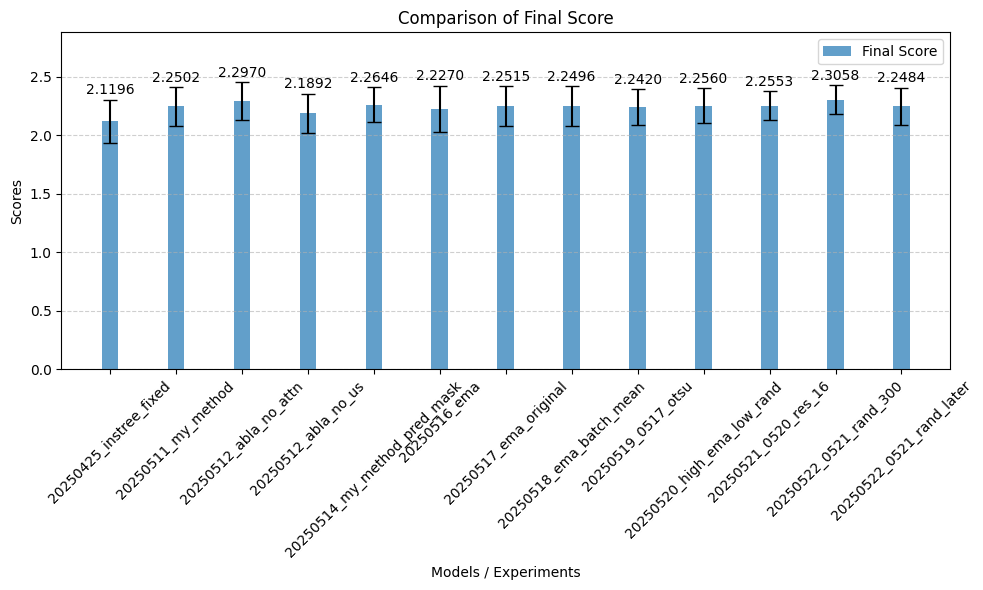

In [55]:
def plot_all_scores_one_plot(score_keepers):
    # Extracting model names and experiment names
    model_names = [sk.model_name for sk in score_keepers]
    exp_names = [sk.exp_name for sk in score_keepers]

    # Metrics data
    metrics = ["final_score"]
    means = {
        "final_score": [sk.metric['final_score'][0] for sk in score_keepers],
    }
    stds = {
        "final_score": [sk.metric['final_score'][1] for sk in score_keepers],
    }

    x = np.arange(len(score_keepers))  # x locations for the bars
    width = 0.25  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plots for each metric
    ax.bar(x, means["final_score"], width, yerr=stds["final_score"], capsize=5, label='Final Score', alpha=0.7)

    # Add numerical values on top of the bars
    for i in range(len(score_keepers)):
        ax.text(x[i], means["final_score"][i] + stds["final_score"][i] + 0.02,  # Position above the bar
                f'{means["final_score"][i]:.4f}', ha='center', va='bottom', color='black')

    # Labels and Titles
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Final Score')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.set_ylim(0, max(means["final_score"]) * 1.25)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

plot_all_scores_one_plot(sk_list)